# [ADA-2020]: P4-milestone
### Group project: Friendship and home position

**Objective**: Inspect the difference in quantity, quality and distribution of friends according to where a person lives

**Authors**: ADA Dream Team

**Study paper**: Eunjoon Cho, Seth A. Myers and Jure Leskovec, *Friendship and Mobility: User Movement in Location-Based Social Network*, Standford University, 2011

**Datasets**:
1. Gowalla dataset: https://snap.stanford.edu/data/loc-gowalla.html. A dataset from the paper. Checkins of users and friends relationship.
2. Brightkite dataset: https://snap.stanford.edu/data/loc-Brightkite.html. A dataset from the paper. Checkins of users and friends relationship.
3. Compilation of UNData: https://www.kaggle.com/sudalairajkumar/undata-country-profiles. Different characteristics for each country.
4. Compilation of USGovt: https://www.kaggle.com/fernandol/countries-of-the-world. More characteristics for each country.
5. happiness2020.pkl and countries_info.csv from "tutorial 01- Handling data", extracted from the World Happiness Report of the United Nations Sustainable Development Solution Network. More characteristics for each country.

**Method**: The method that will be used here is the following:

<span style="color:red">!! ADD WHOLE METHOD (SUMMARY)!!</span>

**Others**: 
The abstract as well as the research questions can be found on the README.md.

In [1]:
#Librairies

#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Convert country names to ISO codes
import pycountry 
import pycountry_convert 

#Convert longitudes and latitudes to country
import reverse_geocoder 

#Plot country map
import cartopy 
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon
import matplotlib.colors as mcolors

#Library for map color to float
import matplotlib.cm as cm

#Library to normalize/standarize values
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Statistical tests
from bioinfokit.analys import stat
from scipy import stats

#Clustering method
from sklearn.mixture import GaussianMixture

In [2]:
#Global constants
PATH = "data/"

## 0. Extraction of the data, preprocessing and merge
In this section, the different dataset will be loaded and preprocessed. Preprocess is the same as the one presented in the tutorial and in our previous milestone. The countries dataset will be merged together to form a big dataset with all the data about each country.

### 0.1 Users dataset
Gowalla and Brightkite are social networks. Their dataset are composed of checkins of each users (place, date, ...) and their friendship relations.

In [3]:
#Extraction parameters
EXTENSION = ".txt.gz"
SEPARATOR = "\t"
CHECKIN_COLUMNS_NAME = ["user", "check-in time", "latitude", "longitude", "location id"]
EDGE_COLUMNS_NAME = ["friend1", "friend2"]
#Extract dataframe from .txt.gz (tabulated separated without header)
user = "IDS"
if user == "ANDRES":
    gowalla_edges = pd.read_csv(PATH+"Gowalla_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"Gowalla_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    bright_edges = pd.read_csv(PATH+"Brightkite_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"Brightkite_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)

elif user == "IDS":
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
elif user == "THIB":
    print("Add your import")
else:
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)


#Remove from checkin some invalid points (null data and incoherent latitudes)
bright_0_lat = bright_checkins[bright_checkins["latitude"] == 0]
bright_0_lat_long = bright_0_lat[bright_0_lat["longitude"] == 0]
bright_checkins = bright_checkins.drop(bright_0_lat_long.index)
bright_big_lat = bright_checkins[bright_checkins["latitude"]>90]
bright_checkins = bright_checkins.drop(bright_big_lat.index)
bright_small_lat = bright_checkins[bright_checkins["latitude"]<-90]
bright_checkins = bright_checkins.drop(bright_small_lat.index)

gowalla_0_lat = gowalla_checkins[gowalla_checkins["latitude"] == 0]
gowalla_0_lat_long = gowalla_0_lat[gowalla_0_lat["longitude"] == 0]
gowalla_checkins = gowalla_checkins.drop(gowalla_0_lat_long.index)
gowalla_big_lat = gowalla_checkins[gowalla_checkins["latitude"]>90]
gowalla_checkins = gowalla_checkins.drop(gowalla_big_lat.index)
gowalla_small_lat = gowalla_checkins[gowalla_checkins["latitude"]<-90]
gowalla_checkins = gowalla_checkins.drop(bright_small_lat.index)

#Sample dataframe to analyze and verify structure
#bright_edges.sample(10)
bright_checkins.sample(10)
#gowalla_edges.sample(10)
#gowalla_checkins.sample(10)

,user,check-in time,latitude,longitude,location id
2074742,8080,2008-05-18T16:39:36Z,42.500558,-90.664572,ed4b47c0a22411dda149bbf7dfa7b8f3
3684450,21699,2009-04-11T02:43:03Z,35.133491,-81.042553,8a418dcabc9f11ddb696003048c0801e
4706841,55396,2009-08-27T17:51:21Z,37.084227,-94.513281,ebfb395ca22411ddaa8ebb052ed97bef
2857302,12053,2008-10-16T22:52:36Z,40.724808,-73.992767,b5c48c849bcc11dda0fc003048c10834
1329299,4613,2010-07-26T22:28:17Z,33.795219,-84.403636,688b6390e4e2ba8208c0178ea99da75ec68b89f9
1968182,7648,2009-12-17T14:08:40Z,42.849346,-2.688249,dac545ab7f2878fc3d5cec394511ab5f
4533964,44481,2009-02-24T03:18:00Z,-31.864789,115.904290,5209e6f4021911de8d3c003048c10834
3204238,13846,2009-11-14T00:04:05Z,-36.860040,174.748431,1abf46b7154f5c8d80c494d26214586a
266867,574,2008-10-25T17:11:27Z,40.715356,-73.965604,5c3ce078a2af11ddb65f003048c0801e
1068467,2993,2009-08-04T10:46:03Z,28.500606,-16.200424,418d24e80d011debd40003048c0801e


### 0.2 Countries dataset
Three different dataset with informations about countries will be used. The first one is from the World Happiness Report of the United Nations Sustainable Development Solution Network, it was presented in the Tutorial of this class; it will be refered as country_WHR (for World Happiness Report). The second one is a compilation (from https://www.kaggle.com/sudalairajkumar/undata-country-profiles) of data from the UN (http://data.un.org/); it will refered as country_UN. The last one is also a compilation (https://www.kaggle.com/fernandol/countries-of-the-world) of data from the CIA (https://www.cia.gov/library/publications/the-world-factbook/); it will be refered as country_CIA.

First, we load and preprocess each one. Then we merge all their information into a big dataset; countries_features.

#### 0.2.1  World Happiness Report (WHR)

In [4]:
#Load data
countries = pd.read_csv(PATH+"countries_info.csv")
happiness = pd.read_pickle(PATH+"happiness2020.pkl")

#Lower case countries from happiness so merge will be possible
happiness["country"] = happiness["country"].str.lower()
#Change column name so they will merge (not duplicated) #!may exist a simpler alternative in the merge options
names = countries.columns.tolist()
names[names.index("country_name")] = "country"
countries.columns = names
#Merge
country_WHR = pd.merge(happiness, countries, left_on = "country", right_on = "country")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_WHR = country_WHR.dropna(axis = 1)

#Restore first letter as upper case for latter use
country_WHR.country = country_WHR.country.str.title()

#Sample dataframe to analyze and verify structure
country_WHR.sample(4)

,country,happiness_score,social_support,healthy_life_expectancy,freedom_of_choices,generosity,perception_of_corruption,world_region,area,population
87,Netherlands,7.4489,0.939139,72.300919,0.908548,0.207612,0.364717,Western Europe,41526,16491461
46,Guinea,4.9493,0.637573,54.467800,0.706847,0.076328,0.761794,Sub-Saharan Africa,245857,9690222
24,China,5.1239,0.798761,69.289192,0.898518,-0.181426,0.753971,East Asia,9596960,1313973713
97,Philippines,6.0060,0.846730,61.926762,0.915463,-0.105463,0.733634,Southeast Asia,300000,89468677


#### 0.2.2  United Nation Compilation (UN)

In [5]:
#Converts the ratio string ("x/y") to the corresponding float
def string_div_to_float(my_string):
    try:
        num, denom = my_string.split('/')
        return float(num) / float(denom)
    except ValueError: #some of the data have ".../..." as a ratio...
        return -100

In [6]:
#Load data (Some datasets represents ratio as such strings "x/y", we will convert it with a float resulting of the division)
country_UN = pd.read_csv(PATH+"country_profile_variables.csv", converters={"Labour force participation (female/male pop. %)":string_div_to_float, "Life expectancy at birth (females/males, years)":string_div_to_float,"Education: Primary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float, "Education: Tertiary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"Population age distribution (0-14 / 60+ years, %)":string_div_to_float, "Forested area (% of land area)":string_div_to_float,"Education: Secondary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"International migrant stock (000/% of total pop.)":string_div_to_float,"Energy supply per capita (Gigajoules)":string_div_to_float,"Pop. using improved drinking water (urban/rural, %)":string_div_to_float})

#Treat some aberrations
country_UN = country_UN.replace("~0.0",0)
country_UN = country_UN.replace("...",np.nan)

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_UN = country_UN.dropna(axis = 1)

#Remove Guadeloupe and Mayotte that are french
country_UN = country_UN[country_UN.country != "Guadeloupe"]
country_UN = country_UN[country_UN.country != "Mayotte"]

#Sample dataframe to analyze and verify structure
country_UN.head(10)

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,0.278195,27.7,42,2.1,32.666667,63,5,1.663830,1.670370,-99
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,1.398357,22.9,130,28.2,2.850000,84,36,0.996849,1.058758,-99
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,1.560554,31.6,135,0.8,39.297297,5900,55,1.030562,1.092457,-99
3,American Samoa,Polynesia,199,56,278.2,103.6,-99,-99,-99.0,-99,...,-100.000000,-99.0,92,87.9,-100.000000,-99,-99,1.000000,1.000000,-99
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,-100.000000,32.1,13,34.0,0.078125,1,119,1.000000,1.000000,-99
5,Angola,MiddleAfrica,1246700,29784,23.9,96.2,117955,3.0,4714.1,6.8,...,0.788462,38.2,146,46.5,24.857143,3902,25,2.673759,3.937778,-99
6,Anguilla,Caribbean,91,15,165.7,97.6,320,2.9,21879.6,2.3,...,-100.000000,-99.0,52,61.1,0.010204,0,136,-100.000000,-100.000000,-99
7,Antigua and Barbuda,Caribbean,442,102,231.8,92.3,1356,4.1,14764.5,1.9,...,2.059603,11.1,55,22.3,0.086207,-99,84,1.000000,1.000000,-99
8,Argentina,SouthAmerica,2780400,44271,16.2,95.9,632343,2.4,14564.5,6.0,...,1.620472,38.9,256,10.0,43.404255,3167,85,0.990000,0.978637,-99
9,Armenia,WesternAsia,29743,2930,102.9,88.8,10529,3.0,3489.1,19.0,...,1.127404,9.9,114,11.7,3.055556,48,46,1.000000,1.230179,-99


#### 0.2.3  Central Intelligence Agency Compilation (CIA)

In [7]:
#Load data
country_CIA = pd.read_csv(PATH+"countries of the world.csv")

#Same country index name
country_CIA = country_CIA.rename(columns = {"Country":"country"})

#Change commas with dot
country_CIA = country_CIA.stack().str.replace(',','.').unstack()

#Remove Guadeloupe and Mayotte that are french and Virgin Islands that are american
country_CIA = country_CIA[country_CIA.country != "Guadeloupe "]
country_CIA = country_CIA[country_CIA.country != "Mayotte "]
country_CIA = country_CIA[country_CIA.country != "Virgin Islands "]

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_CIA = country_CIA.dropna(axis = 1)

#Sample dataframe to analyze and verify structure
country_CIA.sample(4)

,country,Region,Pop. Density (per sq. mi.),Coastline (coast/area ratio)
27,Brazil,LATIN AMER. & CARIB,22.1,0.09
36,Canada,NORTHERN AMERICA,3.3,2.02
108,Kiribati,OCEANIA,130.0,140.94
117,Liberia,SUB-SAHARAN AFRICA,27.3,0.52


#### 0.2.4 Merge the three datasets
The three datasets will be merged in this section. To be able to merge them we need a common identifier, to do so we use the pycountry library. We did not found a library able to work with pandas so we have to do a lambda iteration, which is reasonable as the number of countries is not incredeibly large and we only do it once. 

Note that the WHR dataset is smaller than the two others. Also note that during this conversion some countries are not correctly identified and so are removed, however these countries are in most cases small islands or countries in development which may have very little nor no data for the networks dataset.

In [8]:
#from https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry
# convert country name in alpha 3 name
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

In [9]:
#Change country names to alpha3 so they can be compared (takes ~ 1 minute)
country_WHR['alpha3_name'] = country_WHR.country.apply(lambda name: do_fuzzy_search(name))
country_UN['alpha3_name'] = country_UN.country.apply(lambda name: do_fuzzy_search(name))
country_CIA['alpha3_name'] = country_CIA.country.apply(lambda name: do_fuzzy_search(name))

#Remove the countries that received invalid alpha3 number
country_WHR = country_WHR.dropna()
country_UN = country_UN.dropna()
country_CIA = country_CIA.dropna()
#Nigeria and Niger have the same alpha3 code
country_WHR = country_WHR[country_WHR.alpha3_name != "NGA"] 
country_UN = country_UN[country_UN.alpha3_name != "NGA"]
country_CIA = country_CIA[country_CIA.alpha3_name != "NGA"]
#Same for best and worst Korea
country_WHR = country_WHR[country_WHR.alpha3_name != "PRK"] 
country_UN = country_UN[country_UN.alpha3_name != "PRK"]
country_CIA = country_CIA[country_CIA.alpha3_name != "PRK"]

#Remove the information repeated accross datasets
TO_REMOVE_WHR = ["healthy_life_expectancy", "world_region", "area", "population"]
TO_REMOVE_CIA = ["Region"]
country_WHR = country_WHR.drop(columns = TO_REMOVE_WHR)
country_CIA = country_CIA.drop(columns = TO_REMOVE_CIA)

In [10]:
#Merge the different datasets
countries_features = country_WHR.merge(country_UN, left_on = "alpha3_name", right_on = "alpha3_name", how="inner")
countries_features = countries_features.merge(country_CIA, left_on = "alpha3_name", right_on = "alpha3_name", how="inner")

#Change names and remove repeated columns
countries_features = countries_features.drop(columns = ["country_x"])
countries_features = countries_features.rename(columns = {"country_y":"country"})
countries_features = countries_features.loc[:, ~countries_features.columns.duplicated()]

#Sample dataframe to analyze and verify structure
countries_features.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3_name,country,Region,Surface area (km2),Population in thousands (2017),...,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI),Pop. Density (per sq. mi.),Coastline (coast/area ratio)
47,5.9532,0.821870,0.870603,0.086969,0.801132,HND,Honduras,CentralAmerica,112492,9265,...,301,42.1,7.916667,105,28,1.162291,1.115830,-99,65.4,0.73
121,6.4401,0.922811,0.892395,-0.101103,0.635994,URY,Uruguay,SouthAmerica,173626,3457,...,106,10.4,3.350000,113,58,1.064963,1.043197,-99,19.5,0.37
87,5.6933,0.689062,0.734834,0.044900,0.745705,PAK,Pakistan,SouthernAsia,796095,197016,...,140,2.0,184.777778,2202,17,1.044494,1.626223,-99,206.2,0.13
3,5.9747,0.900568,0.831132,-0.194914,0.842010,ARG,Argentina,SouthAmerica,2780400,44271,...,256,10.0,43.404255,3167,85,0.990000,0.978637,-99,14.4,0.18


From all the features we remove the ones that we consider uninteresting for our application or repeated in different ways (density of population and total population).

In [11]:
TO_REMOVE = ["Surface area (km2)","GDP: Gross domestic product (million current US$)", "Economy: Agriculture (% of GVA)","Economy: Industry (% of GVA)", "Economy: Services and other activity (% of GVA)","Agricultural production index (2004-2006=100)","Food production index (2004-2006=100)","Seats held by women in national parliaments %","Threatened species (number)","CO2 emission estimates (million tons/tons per capita)","Energy production, primary (Petajoules)","Pop. using improved drinking water (urban/rural, %)","Net Official Development Assist. received (% of GNI)"]
countries_features = countries_features.drop(columns=TO_REMOVE)

In the end, we have a dataset with 127 countries (there was 131 valid countries in the WHR dataset). In total there is 57 columns. So there is 55 features for each country, they are:

In [12]:
features = countries_features.columns
for feature in features:
    if(feature != "country" and feature != "alpha3_name"):
        print(feature)

happiness_score
social_support
freedom_of_choices
generosity
perception_of_corruption
Region
Population in thousands (2017)
Population density (per km2, 2017)
Sex ratio (m per 100 f, 2017)
GDP growth rate (annual %, const. 2005 prices)
GDP per capita (current US$)
Labour force participation (female/male pop. %)
Population growth rate (average annual %)
Urban population (% of total population)
Urban population growth rate (average annual %)
Life expectancy at birth (females/males, years)
Population age distribution (0-14 / 60+ years, %)
International migrant stock (000/% of total pop.)
Health: Total expenditure (% of GDP)
Education: Primary gross enrol. ratio (f/m per 100 pop.)
Education: Secondary gross enrol. ratio (f/m per 100 pop.)
Education: Tertiary gross enrol. ratio (f/m per 100 pop.)
Individuals using the Internet (per 100 inhabitants)
Forested area (% of land area)
Energy supply per capita (Gigajoules)
Pop. Density (per sq. mi.)
Coastline (coast/area ratio)


The country in our dataset are represented above (code copied by https://github.com/SciTools/cartopy/issues/1303 and exception error by https://stackoverflow.com/questions/63943614/python-cartopy-how-to-solve-polygon-object-error):

In [13]:
#Color a counter (indicated by its ISO code) in a color
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            return ax

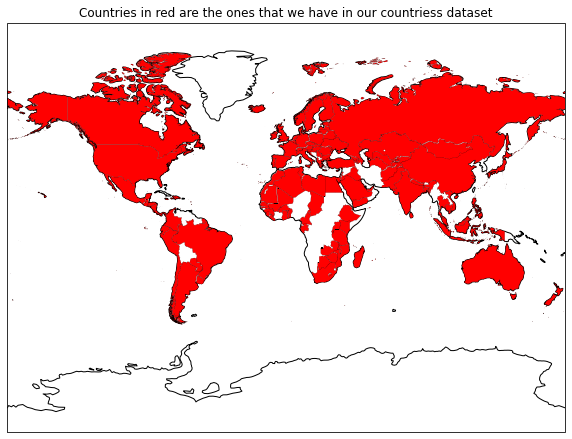

In [14]:
#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features.alpha3_name :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that we have in our countriess dataset")
plt.show()

## 1. Compute home position
Average the home position of the users. This is done like explained in the paper. The implementation is exactly the same as what was done for P2-milestone and so here we just load the result. The jupyter notebook that explain this can be found in the git under the name "replication_report".

In [15]:
gowalla_home_pos_light = pd.read_csv(PATH+"g_home.csv").set_index("user")
bright_home_pos_light = pd.read_csv(PATH+"b_home.csv").set_index("user")

In [16]:
#Sample dataframe to analyze and verify structure
#bright_home_pos_light.sample(4)
gowalla_home_pos_light.sample(4)

,lat,long
user,,
29275,36.107588,-86.737133
100157,38.739281,-9.377073
125894,35.067521,-82.372525
89311,57.697957,11.944012


## 2. Compute nationality and remove non used countries

### 2.1 Compute nationality of the users
Convert longitude latitude to country. To do so we use the reverse_geocoder library.

In [17]:
#convert country name in alpha 2 name (one library return alpha2 from long lat, not country name)
def alpha2_to_country(alpha2_code):
    try:
        result = pycountry_convert.country_alpha2_to_country_name(alpha2_code)
    except Exception:
        result = np.nan
    return result

In [18]:
#Create new dataset
bright_home_complete = bright_home_pos_light
gowalla_home_complete = gowalla_home_pos_light

#Convert long-lat peer in tupple so it is easier for the library
bright_longlat_tupple = list(zip(bright_home_pos_light.lat, bright_home_pos_light.long))
gowalla_longlat_tupple = list(zip(gowalla_home_pos_light.lat, gowalla_home_pos_light.long))

#Search the localisation of each datapoint
bright_home_complete["loc"] = reverse_geocoder.search(bright_longlat_tupple)
gowalla_home_complete["loc"] = reverse_geocoder.search(gowalla_longlat_tupple)

#Separate the localisation information in the different part (name of the city, admin district, country code)
bright_home_complete = pd.DataFrame(bright_home_complete['loc'].tolist(), index=bright_home_complete.index)
gowalla_home_complete = pd.DataFrame(gowalla_home_complete['loc'].tolist(), index=gowalla_home_complete.index)

#Convert country code to country name
bright_home_complete['country'] = bright_home_complete.cc.apply(lambda cc: alpha2_to_country(cc))
gowalla_home_complete['country'] = gowalla_home_complete.cc.apply(lambda cc: alpha2_to_country(cc))

#Remove the useless columns
TO_REMOVE = ["name","admin1","admin2","cc","lat","lon"]
bright_nat = bright_home_complete.drop(columns = TO_REMOVE)
gowalla_nat = gowalla_home_complete.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
bright_nat.sample(4)
#gowalla_nat.sample(4)

Loading formatted geocoded file...


,country
user,
3106,United States
30478,United States
53363,Sweden
42452,United States


### 2.2 Find less used countries and remove them
To decide whatever we keep or not a country we compute its users density (sum of the two applications). 

The minimum density is set to 1 person over 100'000 in one country that have th application. It may seem very few, however the dataset has very low density for all countries (see plot and description above, only green are availible with our density) and we need to have at least some countries to compare.

<span style="color:red">DISCUSS THIS CHOICE</span> 

In [19]:
#Count the users of each country
bright_countries_count = bright_home_complete.country.value_counts()
gowalla_countries_count = gowalla_home_complete.country.value_counts()
#Add alpha3 code for merging
l_idx = []
for idx in bright_countries_count.index:
    l_idx.append(do_fuzzy_search(idx))
bright_count = pd.DataFrame(bright_countries_count)
bright_count["alpha3_name"] = l_idx
l_idx = []
for idx in gowalla_countries_count.index:
    l_idx.append(do_fuzzy_search(idx))
gowalla_count = pd.DataFrame(gowalla_countries_count)
gowalla_count["alpha3_name"] = l_idx

#Remove some colonies or duplicated codes... (detected with bright_count.alpha3_name.duplicated())
bright_count = bright_count[bright_count.index != "Nigeria"]
bright_count = bright_count[bright_count.index != "Niger"]
bright_count = bright_count[bright_count.index != "Curaçao"]
bright_count = bright_count[bright_count.index != "Guadeloupe"]

In [20]:
#Do a safety guard
countries_features_temp = countries_features

#Add the number of users to the countries features
countries_features_temp = countries_features_temp.merge(bright_count, left_on = "alpha3_name", right_on = "alpha3_name", how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"country_x":"country"})
countries_features_temp = countries_features_temp.rename(columns = {"country_y":"bright_count"})
countries_features_temp = countries_features_temp.merge(gowalla_count, left_on = "alpha3_name", right_on = "alpha3_name", how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"country_x":"country"})
countries_features_temp = countries_features_temp.rename(columns = {"country_y":"gowalla_count"})
#Replace the NaN values to 0
countries_features_temp = countries_features_temp.fillna(0)

#Sum the users of each application
countries_features_temp["users"] = countries_features_temp["bright_count"] + countries_features_temp["gowalla_count"]
#Compute the density of users in the population
countries_features_temp["density_users"] = countries_features_temp["users"]/(countries_features_temp["Population in thousands (2017)"]*1000)

count    1.270000e+02
mean     4.359306e-05
std      1.863250e-04
min      0.000000e+00
25%      1.730598e-07
50%      1.578898e-06
75%      1.958827e-05
max      1.892947e-03
Name: density_users, dtype: float64


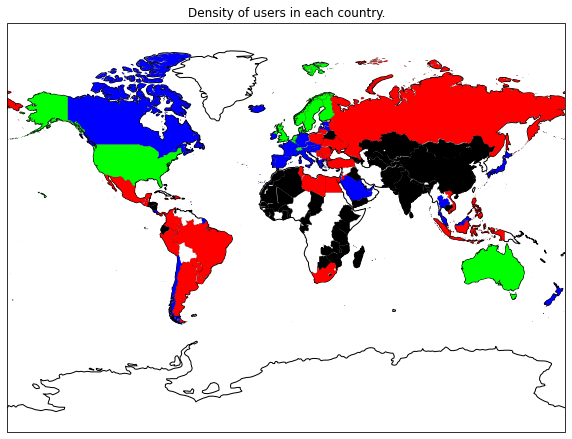

In [21]:
# Plot the density distribution (add Alpha 3 just for the plot)
temp = countries_features_temp.copy()
temp['alpha3_name'] = temp.country.apply(lambda name: do_fuzzy_search(name))

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.density_users > 1e-4):
        color = (0,1,0)
    elif(t.density_users > 1e-5):
        color = (0,0,1)
    elif(t.density_users > 1e-6):
        color = (1,0,0)
    area(ax, t.alpha3_name, color)
    
plt.title("Density of users in each country.")
print(temp.density_users.describe())

In [22]:
#Parameter
MIN_DENSITY = 1e-5

#keep only the countries that have a minimum density of users
countries_features_clean = countries_features_temp[countries_features_temp["density_users"] > MIN_DENSITY]
valid_countries_alpha3 = countries_features_clean.alpha3_name.values

#Remove the useless columns
TO_REMOVE = ["bright_count", "gowalla_count","users","density_users","Population in thousands (2017)"]
countries_features_clean = countries_features_clean.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
countries_features_clean.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3_name,country,Region,"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",...,International migrant stock (000/% of total pop.),Health: Total expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Individuals using the Internet (per 100 inhabitants),Forested area (% of land area),Energy supply per capita (Gigajoules),Pop. Density (per sq. mi.),Coastline (coast/area ratio)
118,6.7908,0.849181,0.941346,0.123451,0.594502,ARE,United Arab Emirates,WesternAsia,112.4,262.4,...,91.573529,3.6,0.994002,-100.000000,-100.000000,56,9.112069,0.996,31.4,1.59
61,6.1021,0.846475,0.872366,-0.100185,0.760849,KWT,Kuwait,WesternAsia,232.1,134.9,...,38.941576,3.0,1.005859,1.164399,1.622549,49,3.755906,1.000,135.7,2.80
43,5.5150,0.814380,0.541345,-0.300907,0.859931,GRC,Greece,SouthernEurope,86.6,96.9,...,109.955752,8.1,0.989806,0.944292,0.997368,374,11.032787,1.000,81.0,10.37
29,6.9109,0.914431,0.818537,-0.230862,0.858446,CZE,Czechia,EasternEurope,137.5,96.7,...,106.605263,7.4,1.003012,1.009515,1.407749,53,10.489130,1.000,129.8,0.00


There are 127 countries availible.


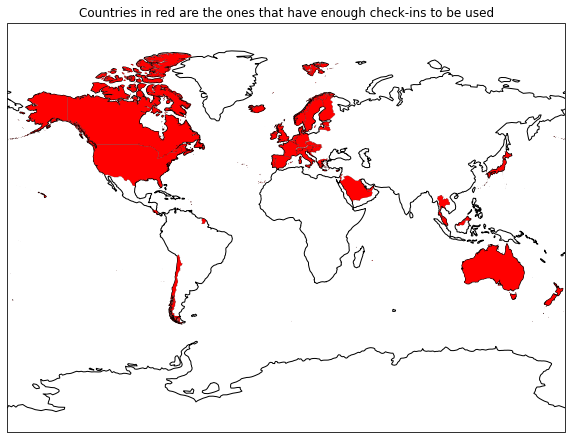

In [23]:
# Plot the countries in the final dataset (add Alpha 3 just for the plot)
temp = countries_features_clean
temp['alpha3_name'] = temp.country.apply(lambda name: do_fuzzy_search(name))

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in temp.alpha3_name :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that have enough check-ins to be used")
print("There are "+str(countries_features_temp.shape[0])+" countries availible.")
plt.show()

The final number of country is low, but we have to have meaningful results.

### 2.3 Cluster the countries
Try to find if some groups emerge from the countries' features. First data will be normalized (with a StandrardScaler), then we will use k-means with a set of k-values to find the optimal number of clusters. Finally, we show the emerging clusters.

In [24]:
#Generate a list of colors for the plots
colors = mcolors.BASE_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]
color_names.remove("w") #pop white
color_names.extend(["gray","brown","orange","lightgreen","cyan"])
NB_MAX_GRP = len(color_names)

In [25]:
#Save the indetificators that we need
countries_names = countries_features_clean.country
countires_codes = countries_features_clean.alpha3_name

#Remove the information that can not be used for clustering
TO_REMOVE = ["country","alpha3_name","Region"]
country_clustering = countries_features_clean.drop(columns=TO_REMOVE)

#Standarize the data ((x-mean)/var)
scaler = preprocessing.StandardScaler()
country_clustering = pd.DataFrame(scaler.fit_transform(country_clustering))

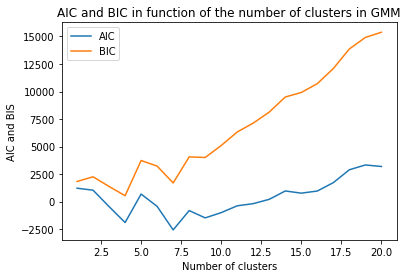

In [26]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = 21

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, init_params = "kmeans").fit(country_clustering)
    all_aic.append(gmm.aic(country_clustering))
    all_bic.append(gmm.bic(country_clustering))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIS")
plt.legend()

From the plot we see that the minimum for both occurs around 6 clusters.

In [27]:
#Compute with our best resut
BEST_NB_CLUSTERS = 6
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100, init_params = "kmeans").fit(country_clustering)
labels = gmm.fit_predict(country_clustering)
res = pd.DataFrame(index = countries_names, data = labels, columns =["labels"])

In [28]:
#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)

features_clusters = res

Label n°0
['Iceland' 'Ireland' 'Luxembourg' 'Norway' 'Switzerland']
Label n°1
['Croatia' 'Czechia' 'Estonia' 'Hungary' 'Latvia' 'Portugal' 'Slovakia'
 'Slovenia']
Label n°2
['Australia' 'Austria' 'Canada' 'Denmark' 'Finland' 'France' 'Germany'
 'Netherlands' 'New Zealand' 'Sweden' 'United Kingdom'
 'United States of America']
Label n°3
['Singapore']
Label n°4
['Bahrain' 'Kuwait' 'Malaysia' 'Saudi Arabia' 'United Arab Emirates']
Label n°5
['Belgium' 'Chile' 'Costa Rica' 'Cyprus' 'Greece' 'Israel' 'Italy' 'Japan'
 'Malta' 'Spain' 'Thailand']


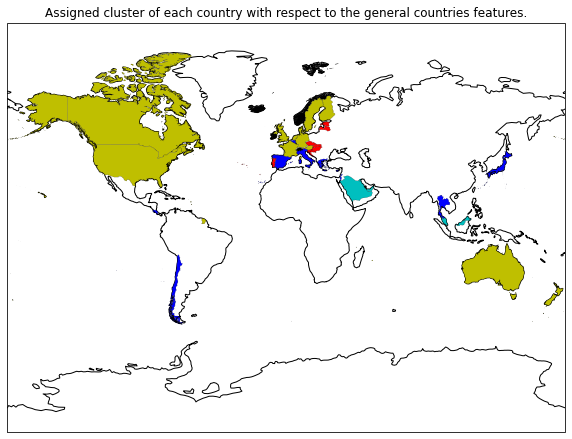

In [29]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, countires_codes.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the general countries features.")

## 3. Friends charachteristics

### 3.1 Compute Quantitative Charactistics


In [30]:
# Adding to the datasets the nationality of each friend
gowalla_edges = gowalla_edges.set_index("friend1")
gowalla_edges["friend1_nat"] = gowalla_nat["country"]
gowalla_edges = gowalla_edges.reset_index().set_index("friend2")
gowalla_edges["friend2_nat"] = gowalla_nat["country"]
gowalla_edges = gowalla_edges.reset_index()

bright_edges = bright_edges.set_index("friend1")
bright_edges["friend1_nat"] = bright_nat["country"]
bright_edges = bright_edges.reset_index().set_index("friend2")
bright_edges["friend2_nat"] = bright_nat["country"]
bright_edges = bright_edges.reset_index()

# Dropping those edges which have al least one node with Nan nationality
gowalla_edges = gowalla_edges.dropna()
bright_edges = bright_edges.dropna()

#bright_edges.sample(5)
gowalla_edges.sample(5)

,friend2,friend1,friend1_nat,friend2_nat
551799,25105,10057,Sweden,Sweden
503517,4571,8307,Australia,United States
1841535,97383,169772,Sweden,Sweden
453471,1469,6892,United States,Philippines
170411,2,1512,Austria,United States


In [31]:
# Add the home of each users
#FIRST THE LATITUDE AND LONGITUDE OF THE FIRST USER IS OBTAINED SETTING THIS USER AS THE INDEX AND USING THE "Go_home" DATA FRAME
gowalla_edges = gowalla_edges.set_index("friend1")
gowalla_edges["friend1_lat"] = gowalla_home_pos_light["lat"]
gowalla_edges["friend1_lon"] = gowalla_home_pos_light["long"]
#THEN THE PROCESS IS REPEATED FOR THE SECOND USER
gowalla_edges = gowalla_edges.reset_index().set_index("friend2")
gowalla_edges["friend2_lat"] = gowalla_home_pos_light["lat"]
gowalla_edges["friend2_lon"] = gowalla_home_pos_light["long"]
#FINALLY THE INDEX IS RESETED SO THAT ALL INFORMATION IS EQUALLY ACCESIBLE
gowalla_edges = gowalla_edges.reset_index()

#SAME FOR BRIGHTKITE DATASET
bright_edges = bright_edges.set_index("friend1")
bright_edges["friend1_lat"] = bright_home_pos_light["lat"]
bright_edges["friend1_lon"] = bright_home_pos_light["long"]
bright_edges = bright_edges.reset_index().set_index("friend2")
bright_edges["friend2_lat"] = bright_home_pos_light["lat"]
bright_edges["friend2_lon"] = bright_home_pos_light["long"]
bright_edges = bright_edges.reset_index()

In [32]:
#Compute the distance btw the home of the users

# approximate radius of earth in km
R = 6373.0

# Converting grades to radians
gowalla_edges["friend1_lat"] = np.radians(gowalla_edges["friend1_lat"])
gowalla_edges["friend2_lat"] = np.radians(gowalla_edges["friend2_lat"])
gowalla_edges["friend1_lon"] = np.radians(gowalla_edges["friend1_lon"])
gowalla_edges["friend2_lon"] = np.radians(gowalla_edges["friend2_lon"])

# Calculating the difference between latitudes and longitudes
gowalla_edges["lat_dis"] = gowalla_edges["friend2_lat"]-gowalla_edges["friend1_lat"]
gowalla_edges["lon_dis"] = gowalla_edges["friend2_lon"]-gowalla_edges["friend1_lon"]

# Haversine method to compute the distance
gowalla_edges["a"] = np.sin(gowalla_edges["lat_dis"] / 2)**2 + np.cos(gowalla_edges["friend1_lat"]) * np.cos(gowalla_edges["friend2_lat"]) * np.sin(gowalla_edges["lon_dis"] / 2)**2
gowalla_edges["c"] = 2 * np.arctan2(np.sqrt(gowalla_edges["a"]), np.sqrt(1 - gowalla_edges["a"]))

gowalla_edges["distance"] = R * gowalla_edges["c"]


# Same for Brightkite dataset
bright_edges["friend1_lat"] = np.radians(bright_edges["friend1_lat"])
bright_edges["friend2_lat"] = np.radians(bright_edges["friend2_lat"])
bright_edges["friend1_lon"] = np.radians(bright_edges["friend1_lon"])
bright_edges["friend2_lon"] = np.radians(bright_edges["friend2_lon"])

bright_edges["lat_dis"] = bright_edges["friend2_lat"]-bright_edges["friend1_lat"]
bright_edges["lon_dis"] = bright_edges["friend2_lon"]-bright_edges["friend1_lon"]



bright_edges["a"] = np.sin(bright_edges["lat_dis"] / 2)**2 + np.cos(bright_edges["friend1_lat"]) * np.cos(bright_edges["friend2_lat"]) * np.sin(bright_edges["lon_dis"] / 2)**2
bright_edges["c"] = 2 * np.arctan2(np.sqrt(bright_edges["a"]), np.sqrt(1 - bright_edges["a"]))

bright_edges["distance"] = R * bright_edges["c"]

In [33]:
threshold = 50 #km between users

In [34]:
# Creating a new data set with friendship info for each user
# Number of friends
gowalla_friends_ch = pd.DataFrame(gowalla_edges.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
# Number of friends in the same country
gowalla_friends_ch["n_friends_same_country"] = gowalla_edges[gowalla_edges.friend1_nat == gowalla_edges.friend2_nat].groupby("friend1")["friend2"].count()
# Ratio of friends in the same country
gowalla_friends_ch["ratio_friends_same_country"] = gowalla_friends_ch["n_friends_same_country"]/gowalla_friends_ch["n_friends"]
# Number of friends within a distance
gowalla_friends_ch["n_friends_near"] = gowalla_edges[gowalla_edges.distance < threshold].groupby("friend1")["friend2"].count()
# Ratio of friends within a distance
gowalla_friends_ch["ratio_friends_near"] = gowalla_friends_ch["n_friends_near"]/gowalla_friends_ch["n_friends"]

# Same for Brightkite dataset
bright_friends_ch = pd.DataFrame(bright_edges.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
bright_friends_ch["n_friends_same_country"] = bright_edges[bright_edges.friend1_nat == bright_edges.friend2_nat].groupby("friend1")["friend2"].count()
bright_friends_ch["ratio_friends_same_country"] = bright_friends_ch["n_friends_same_country"]/bright_friends_ch["n_friends"]
bright_friends_ch["n_friends_near"] = bright_edges[bright_edges.distance < threshold].groupby("friend1")["friend2"].count()
bright_friends_ch["ratio_friends_near"] = bright_friends_ch["n_friends_near"]/bright_friends_ch["n_friends"]

gowalla_friends_ch = gowalla_friends_ch.fillna(0)
bright_friends_ch = bright_friends_ch.fillna(0)

# Filling Nan values (due to .count() function) with zeros
#bright_friends_ch.sample(5)
gowalla_friends_ch.sample(5)

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,
140446,4,3.0,0.750000,3.0,0.750000
79684,9,4.0,0.444444,4.0,0.444444
172937,4,4.0,1.000000,2.0,0.500000
139215,11,11.0,1.000000,11.0,1.000000
114852,14,14.0,1.000000,12.0,0.857143


### 3.2 Qualitative friendship charachteristics

In [35]:
import datetime

#drop useless columns and sort dataframe
gowalla_checkins["check-in time"] = pd.to_datetime(gowalla_checkins["check-in time"])
gowalla_times = gowalla_checkins[["user", "location id", "check-in time"]]
gowalla_times = gowalla_times.sort_values(["location id", "check-in time"])

bright_checkins["check-in time"] = pd.to_datetime(bright_checkins["check-in time"])
bright_times = bright_checkins[["user", "location id", "check-in time"]]
bright_times = bright_times.sort_values(["location id", "check-in time"])

In [36]:
#time tolerance to define meeting
TOL = 15 #minutes
tol = datetime.timedelta(minutes=TOL)

#compute time differences
gowalla_times["time_diff_with_prev"] = gowalla_times["check-in time"].diff()
gowalla_times["time_diff_with_next"] = gowalla_times["time_diff_with_prev"].shift(-1)

bright_times["time_diff_with_prev"] = bright_times["check-in time"].diff()
bright_times["time_diff_with_next"] = bright_times["time_diff_with_prev"].shift(-1)

#drop check-ins isolated by more than TOL -> Reduces dataset 
bool_prev = (gowalla_times["time_diff_with_prev"] <= tol) & \
            (gowalla_times["time_diff_with_prev"]>= datetime.timedelta(minutes=0))
bool_next = (gowalla_times["time_diff_with_next"] <= tol) & \
            (gowalla_times["time_diff_with_next"]>= datetime.timedelta(minutes=0))

gowalla_times_small = gowalla_times[bool_prev | bool_next ]
gowalla_times_small = gowalla_times_small.sort_values(["location id", "user"]) 
gowalla_times_small = gowalla_times_small.drop(columns = ["time_diff_with_prev", "time_diff_with_next"])

gowalla_times_small["year"] = gowalla_times_small["check-in time"].dt.year
gowalla_times_small["month"] = gowalla_times_small["check-in time"].dt.month
gowalla_times_small["day"] = gowalla_times_small["check-in time"].dt.day


bool_prev = (bright_times["time_diff_with_prev"] <= tol) & \
            (bright_times["time_diff_with_prev"]>= datetime.timedelta(minutes=0))
bool_next = (bright_times["time_diff_with_next"] <= tol) & \
            (bright_times["time_diff_with_next"]>= datetime.timedelta(minutes=0))

bright_times_small = bright_times[bool_prev | bool_next ]
bright_times_small = bright_times_small.sort_values(["location id", "user"]) 

bright_times_small["year"] = bright_times_small["check-in time"].dt.year
bright_times_small["month"] = bright_times_small["check-in time"].dt.month
bright_times_small["day"] = bright_times_small["check-in time"].dt.day


bright_times_small = bright_times_small.drop(columns = ["time_diff_with_prev", "time_diff_with_next"])

bright_times_small

,user,location id,check-in time,year,month,day
1914903,7579,00009b804e2e99002a1d37e3462ebbad,2010-05-18 00:01:16+00:00,2010,5,18
1914902,7579,00009b804e2e99002a1d37e3462ebbad,2010-05-18 00:05:30+00:00,2010,5,18
443973,1082,0000fedfa48d8d632b437efc78bcb96a,2009-10-22 20:34:45+00:00,2009,10,22
443972,1082,0000fedfa48d8d632b437efc78bcb96a,2009-10-22 20:35:38+00:00,2009,10,22
3389571,16400,0001618fd93d0caddb3d401cf84eafc0,2009-12-18 18:19:38+00:00,2009,12,18
...,...,...,...,...,...,...
1471267,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:35:08+00:00,2009,12,4
1471266,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:36:06+00:00,2009,12,4
1471265,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:37:06+00:00,2009,12,4
1471264,5708,ffffeb32ccb10ade87083d4b42d70094,2009-12-04 04:41:05+00:00,2009,12,4


In [37]:
#build dataframe with check-ins relation
gowalla_checkins_relation = gowalla_times_small.merge(gowalla_times_small, on = ["location id", "year", "month", "day"])
bright_checkins_relation = bright_times_small.merge(bright_times_small, on = ["location id", "year", "month", "day"])

#remove same user relations
gowalla_checkins_relation = gowalla_checkins_relation[gowalla_checkins_relation["user_x"] \
                                                      != gowalla_checkins_relation["user_y"]]
bright_checkins_relation = bright_checkins_relation[bright_checkins_relation["user_x"] \
                                                      != bright_checkins_relation["user_y"]]

#compute time difference between users' checkins
gowalla_checkins_relation["time_diff"] = abs(gowalla_checkins_relation["check-in time_x"] - gowalla_checkins_relation["check-in time_y"])
bright_checkins_relation["time_diff"] = abs(bright_checkins_relation["check-in time_x"] - bright_checkins_relation["check-in time_y"])


#filter simulateneous check-ins
gowalla_checkins_relation = gowalla_checkins_relation[gowalla_checkins_relation["time_diff"] <= tol]
bright_checkins_relation = bright_checkins_relation[bright_checkins_relation["time_diff"] <= tol]

bright_checkins_relation.head()

,user_x,location id,check-in time_x,year,month,day,user_y,check-in time_y,time_diff
129,17050,000aa2b5aff5c8baa3afc79316079246,2009-12-12 23:29:18+00:00,2009,12,12,46475,2009-12-12 23:30:38+00:00,0 days 00:01:20
130,46475,000aa2b5aff5c8baa3afc79316079246,2009-12-12 23:30:38+00:00,2009,12,12,17050,2009-12-12 23:29:18+00:00,0 days 00:01:20
431,5161,00204e1a5b3b38239885d598ee136dc54e3b6bba,2008-06-28 16:43:57+00:00,2008,6,28,8705,2008-06-28 16:33:26+00:00,0 days 00:10:31
432,5161,00204e1a5b3b38239885d598ee136dc54e3b6bba,2008-06-28 16:43:57+00:00,2008,6,28,8705,2008-06-28 16:35:47+00:00,0 days 00:08:10
433,8705,00204e1a5b3b38239885d598ee136dc54e3b6bba,2008-06-28 16:33:26+00:00,2008,6,28,5161,2008-06-28 16:43:57+00:00,0 days 00:10:31


In [38]:
#count number of meetings between users
gw_nb_meetings = gowalla_checkins_relation.groupby(["user_x", "user_y"]).count()
gw_nb_meetings = gw_nb_meetings[["time_diff"]]
gw_nb_meetings = gw_nb_meetings.rename(columns = {"time_diff": "meetings"})

bk_nb_meetings = bright_checkins_relation.groupby(["user_x", "user_y"]).count()
bk_nb_meetings = bk_nb_meetings[["time_diff"]]
bk_nb_meetings = bk_nb_meetings.rename(columns = {"time_diff": "meetings"})
bk_nb_meetings

meetings
user_x user_y          
0      1              6
       2            197
       3              1
       4              2
       7             28
...                 ...
58202  58203          1
58203  58202          1
58205  58152          2
       58221          1
58221  58205          1

[73588 rows x 1 columns]

In [39]:
gowalla_edges = gowalla_edges.set_index(["friend1", "friend2"])
bright_edges = bright_edges.set_index(["friend1", "friend2"])

In [40]:
#infer friendship quality features from meetings:
#gowalla
gw_friend_meetings = gowalla_edges.join(gw_nb_meetings, on = ["friend1", "friend2"])
gw_friend_meetings = gw_friend_meetings.fillna(0)

gw_friend_q = gw_friend_meetings.groupby("friend1").max()
gw_friend_q["average meetings"] =  gw_friend_meetings.groupby("friend1").mean().meetings
gw_friend_q = gw_friend_q.rename(columns = {"meetings":"best friend meetings"})
gw_met_friends = gw_friend_meetings[gw_friend_meetings["meetings"] > 0].groupby("friend1").count()
gw_met_friends = gw_met_friends.rename(columns = {"meetings": "met friends"})

gw_friends_q = gw_friend_q.merge(gw_met_friends["met friends"], on = "friend1")


#brightkite
bk_friend_meetings = gowalla_edges.join(bk_nb_meetings, on = ["friend1", "friend2"])
bk_friend_meetings = bk_friend_meetings.fillna(0)

bk_friend_q = bk_friend_meetings.groupby("friend1").max()
bk_friend_q["average meetings"] =  bk_friend_meetings.groupby("friend1").mean().meetings
bk_friend_q = bk_friend_q.rename(columns = {"meetings":"best friend meetings"})
bk_met_friends = bk_friend_meetings[bk_friend_meetings["meetings"] > 0].groupby("friend1").count()
bk_met_friends = bk_met_friends.rename(columns = {"meetings": "met friends"})

bk_friends_q = bk_friend_q.merge(bk_met_friends["met friends"], on = "friend1")

gw_friends_q_f = gw_friends_q[["best friend meetings","average meetings","met friends"]]
bk_friends_q_f = bk_friends_q[["best friend meetings","average meetings","met friends"]]

display(gw_friends_q_f)
display(bk_friends_q_f)

,best friend meetings,average meetings,met friends
friend1,,,
0,10.0,0.210714,45
2,2.0,0.006019,6
4,9.0,1.400000,13
5,1.0,0.004695,3
7,20.0,1.634146,17
...,...,...,...
196445,3.0,3.000000,1
196452,1.0,1.000000,1
196472,3.0,3.000000,1


,best friend meetings,average meetings,met friends
friend1,,,
0,197.0,0.971429,44
1,6.0,0.011429,3
2,197.0,0.213242,25
4,2.0,0.066667,1
5,19.0,0.042254,2
...,...,...,...
43141,1.0,0.100000,1
43143,1.0,0.500000,1
43591,1.0,0.200000,1


### 3.3 Merge all

#### 3.3.1 Merge quantitative and qualitative

In [41]:
g_friends_all = pd.merge(gw_friends_q_f, gowalla_friends_ch, left_index = True, right_index = True)
b_friends_all = pd.merge(bk_friends_q_f, bright_friends_ch, left_index = True, right_index = True)

b_friends_all.sample(4)
#g_friends_all.sample(4)

,best friend meetings,average meetings,met friends,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,,,,
74,1.0,0.333333,1,40,35.0,0.875000,19.0,0.475000
1,6.0,0.011429,3,39,34.0,0.871795,24.0,0.615385
34,11.0,0.111111,1,32,27.0,0.843750,19.0,0.593750
22035,2.0,0.333333,1,4,4.0,1.000000,2.0,0.500000


#### 3.3.2 Merge Brightkite and Gowalla

In [42]:
#Add the nationality of each user
bright_friends_nat = pd.merge(b_friends_all, bright_nat, left_index = True, right_index = True)
gowalla_friends_nat = pd.merge(g_friends_all, gowalla_nat, left_index = True, right_index = True)

#Groupby country and do the mean of each feature
bright_countries_friendships =  bright_friends_nat.groupby(["country"]).mean().reset_index()
gowalla_countries_friendships =  gowalla_friends_nat.groupby(["country"]).mean().reset_index()

#Add the alpha3 code and keep only the countries that are in the country dataset
bright_countries_friendships["alpha3_name"] = bright_countries_friendships.country.apply(lambda name: do_fuzzy_search(name))
bright_countries_friendships = bright_countries_friendships[bright_countries_friendships['alpha3_name'].isin(valid_countries_alpha3)]
gowalla_countries_friendships["alpha3_name"] = gowalla_countries_friendships.country.apply(lambda name: do_fuzzy_search(name))
gowalla_countries_friendships = gowalla_countries_friendships[gowalla_countries_friendships['alpha3_name'].isin(valid_countries_alpha3)]

#Remove useless informations
TO_REMOVE = ["n_friends_same_country", "n_friends_near"]
bright_countries_friendships = bright_countries_friendships.drop(columns = TO_REMOVE)
gowalla_countries_friendships = gowalla_countries_friendships.drop(columns = TO_REMOVE)

In [43]:
bright_countries_friendships

,country,best friend meetings,average meetings,met friends,n_friends,ratio_friends_same_country,ratio_friends_near,alpha3_name
0,Estonia,16.000000,2.840580,1.0,10.500000,0.904545,0.854545,EST
1,Finland,3.000000,0.077832,1.0,29.750000,0.611146,0.469699,FIN
2,France,5.000000,0.238095,1.0,35.000000,0.142857,0.114286,FRA
3,Germany,1.000000,0.053295,1.0,44.000000,0.257812,0.117188,DEU
4,United Kingdom,8.000000,0.148148,1.0,10.000000,0.000000,0.000000,GBR
5,United States,8.183099,0.200588,2.0,57.274648,0.927530,0.534659,USA


In [44]:
#Group Gowalla and Brightkite information (do the mean for ratio and the sum for friends)
full_countries_friendships = pd.merge(bright_countries_friendships, gowalla_countries_friendships, left_on ="alpha3_name", right_on = "alpha3_name")
full_countries_friendships["ratio_friends_near"] = (full_countries_friendships["ratio_friends_near_x"]+full_countries_friendships["ratio_friends_near_y"])/2
full_countries_friendships["ratio_friends_same_country"] = (full_countries_friendships["ratio_friends_same_country_x"]+full_countries_friendships["ratio_friends_same_country_y"])/2
full_countries_friendships["total_nb_friends"] = (full_countries_friendships["n_friends_x"]+full_countries_friendships["n_friends_y"])/2
full_countries_friendships["best friend meetings"] = (full_countries_friendships["best friend meetings_x"]+full_countries_friendships["best friend meetings_y"])/2
full_countries_friendships["average meetings"] = (full_countries_friendships["average meetings_x"]+full_countries_friendships["average meetings_y"])/2
full_countries_friendships["met friends"] = (full_countries_friendships["met friends_x"]+full_countries_friendships["met friends_y"])/2

#Remove or rename information
TO_REMOVE = ["country_y","ratio_friends_near_x","ratio_friends_same_country_x","n_friends_x", "ratio_friends_near_y","ratio_friends_same_country_y","n_friends_y","best friend meetings_x","best friend meetings_y","average meetings_x","average meetings_y","met friends_x","met friends_y"]
full_countries_friendships = full_countries_friendships.drop(columns = TO_REMOVE)
full_countries_friendships = full_countries_friendships.rename(columns = {"country_x":"country"})
full_countries_friendships = full_countries_friendships[full_countries_friendships.country != "Guadeloupe"]
full_countries_friendships = full_countries_friendships[full_countries_friendships.country != "Curaçao"]

#Rename to be utilisable
full_countries_friendships = full_countries_friendships.rename(columns = {"best friend meetings":"best_friend_meetings","average meetings":"average_meetings","met friends":"met_friends"})

#Example
full_countries_friendships.sample(4)

,country,alpha3_name,ratio_friends_near,ratio_friends_same_country,total_nb_friends,best_friend_meetings,average_meetings,met_friends
3,Germany,DEU,0.370972,0.573131,27.804840,3.503143,0.863134,1.410119
5,United States,USA,0.562633,0.946501,36.975754,8.182651,1.175678,2.083794
0,Estonia,EST,0.643182,0.706061,7.875000,14.562500,3.945479,1.000000
4,United Kingdom,GBR,0.296480,0.394479,11.020256,6.989339,0.939575,1.429638


#### 3.3.3 Merge it with the country features

In [45]:
#Give new names for future use
countries_friendships_features = full_countries_friendships
countries_other_features = countries_features_clean

#Merge merged information about friendship and countries features
countries_all_features = pd.merge(countries_friendships_features, countries_other_features, left_on="alpha3_name", right_on="alpha3_name")
countries_all_features = countries_all_features.drop(columns = ["country_y"])
countries_all_features = countries_all_features.rename(columns = {"country_x":"country"})

#Example
countries_all_features.sample(5)

,country,alpha3_name,ratio_friends_near,ratio_friends_same_country,total_nb_friends,best_friend_meetings,average_meetings,met_friends,happiness_score,social_support,...,International migrant stock (000/% of total pop.),Health: Total expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Individuals using the Internet (per 100 inhabitants),Forested area (% of land area),Energy supply per capita (Gigajoules),Pop. Density (per sq. mi.),Coastline (coast/area ratio)
3,Germany,DEU,0.370972,0.573131,27.804840,3.503143,0.863134,1.410119,7.0758,0.898874,...,805.751678,11.3,0.995247,0.943182,0.958393,116,80.887640,1.000000,230.9,0.67
1,Finland,FIN,0.544418,0.683700,18.512681,4.007246,0.879561,1.536232,7.8087,0.954330,...,55.421053,9.7,0.997050,1.094538,1.205549,36,5.500000,1.000000,15.5,0.37
5,United States,USA,0.562633,0.946501,36.975754,8.182651,1.175678,2.083794,6.9396,0.914219,...,3215.662069,17.1,0.997009,1.018614,1.368132,1513,324.339506,1.012220,31.0,0.21
0,Estonia,EST,0.643182,0.706061,7.875000,14.562500,3.945479,1.000000,6.0218,0.934730,...,13.136364,6.4,1.002035,0.992215,1.530686,23,1.317568,1.010101,29.3,8.39
2,France,FRA,0.316877,0.381137,23.037037,5.885185,1.024016,1.296296,6.6638,0.937104,...,643.338843,11.5,0.993377,1.009991,1.226252,278,64.531915,1.000000,111.3,0.63


### 3.4 Plot the friendship features

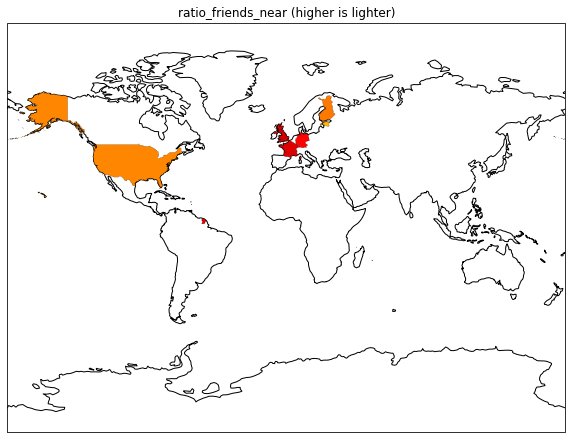

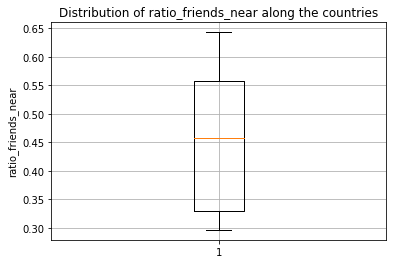

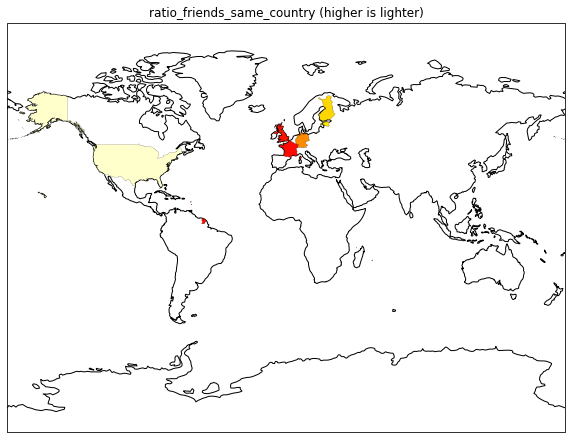

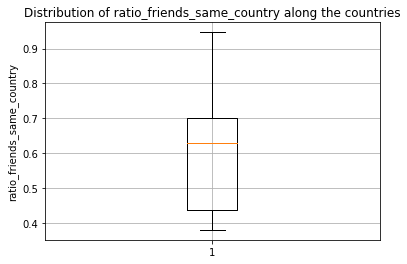

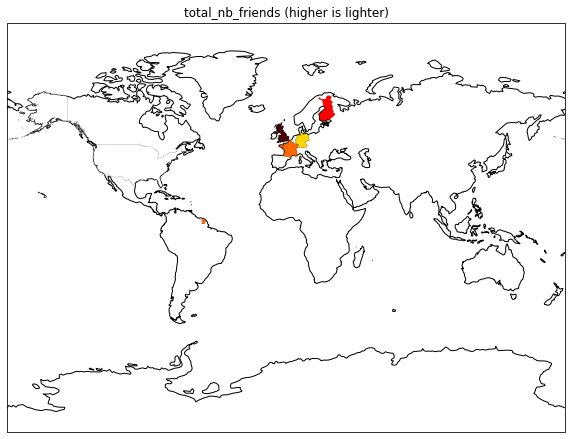

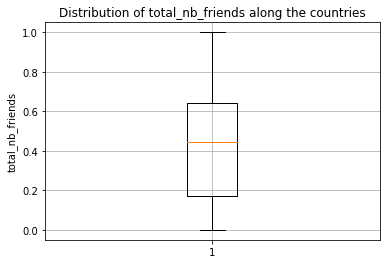

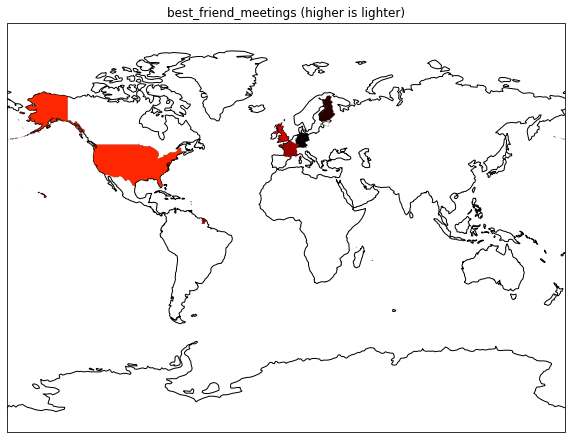

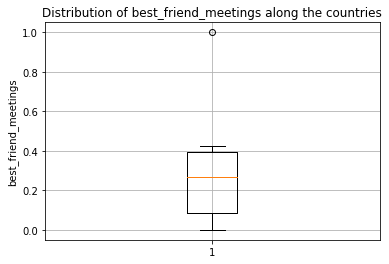

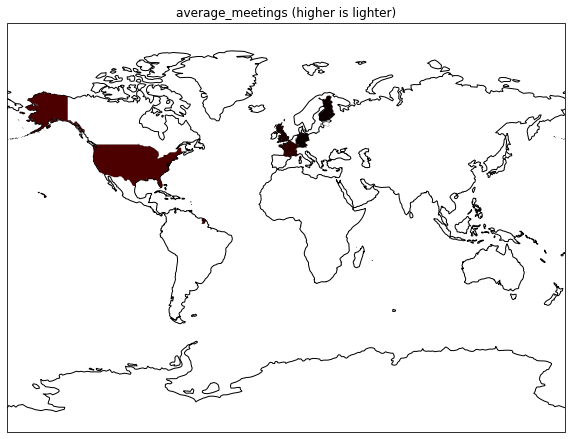

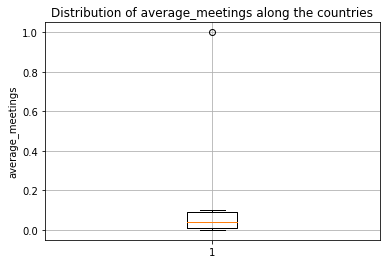

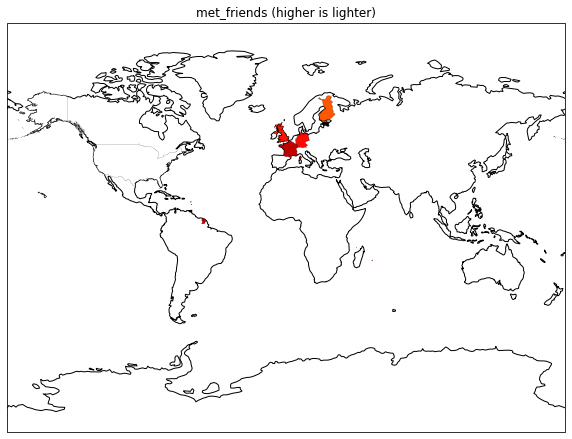

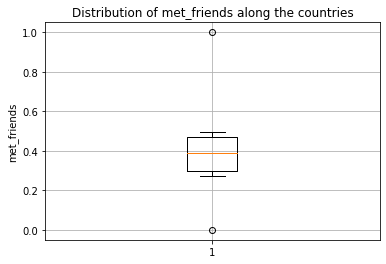

In [46]:
#Min max the value to be printable
scaler = MinMaxScaler()
temp = full_countries_friendships.copy()
temp["total_nb_friends"] = scaler.fit_transform((temp["total_nb_friends"].values).reshape(-1,1))
temp["best_friend_meetings"] = scaler.fit_transform((temp["best_friend_meetings"].values).reshape(-1,1))
temp["average_meetings"] = scaler.fit_transform((temp["average_meetings"].values).reshape(-1,1))
temp["met_friends"] = scaler.fit_transform((temp["met_friends"].values).reshape(-1,1))

features = ["ratio_friends_near","ratio_friends_same_country", "total_nb_friends","best_friend_meetings","average_meetings","met_friends"]

for feature in features:
    #Create the world for the plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.Miller())
    ax.add_feature(cfeature.COASTLINE)

    #Plot all countries
    for i in range(0, temp.shape[0]) :
        color = cm.hot(temp.iloc[i][feature])
        area(ax, temp.iloc[i].alpha3_name, color)

    plt.title(feature+" (higher is lighter)")
    plt.show()
    
    plt.grid()
    plt.boxplot(temp[feature])
    plt.ylabel(feature)
    plt.title("Distribution of "+feature+" along the countries")
    plt.show()

### 3.5 Cluster the friendship informations

In [47]:
#Save id of countries
f_countries_names = full_countries_friendships.country
f_countries_alpha3 =  full_countries_friendships.alpha3_name

#Remove useless information
TO_REMOVE = ["country","alpha3_name"]
countries_friendships = full_countries_friendships.drop(columns = TO_REMOVE)

#Standarize the data ((x-mean)/var)
scaler = preprocessing.StandardScaler()
countries_friendships = pd.DataFrame(scaler.fit_transform(countries_friendships))

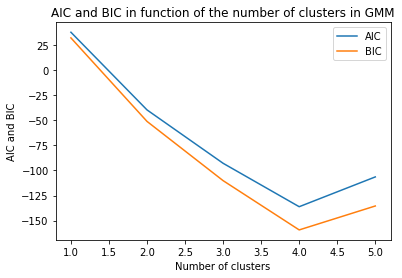

In [48]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = full_countries_friendships.shape[0]

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, init_params = "kmeans").fit(countries_friendships)
    all_aic.append(gmm.aic(countries_friendships))
    all_bic.append(gmm.bic(countries_friendships))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIC")
plt.legend()

The minimum for both metrics is around 31 clusters. That means that the friendships charachteristics are really different from a country to another.

<font color='red'>change best value up and down</font>

In [49]:
#Compute with our best resut
BEST_NB_CLUSTERS = 4
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100)
labels = gmm.fit_predict(countries_friendships)
res = pd.DataFrame(index = f_countries_names, data = labels, columns =["labels"])

#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)
    
f_friendships_clusters = res

Label n°0
['France' 'United Kingdom']
Label n°1
['Finland' 'Germany']
Label n°2
['Estonia']
Label n°3
['United States']


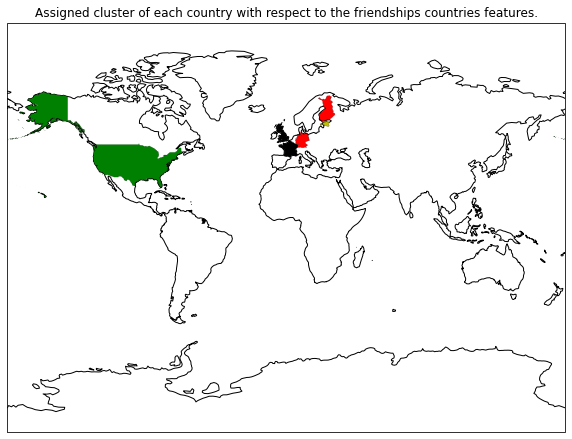

In [50]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, f_countries_alpha3.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the friendships countries features.")

### 3.6 Verify the statistical difference

#### 3.5.1 Anova test 
Standard ANOVA takes as null hypothesis that all the groups distribution are the same. We assume normal distribution and independence.

In [51]:
print("\nQUANTITATIVE FEATURES\n")

datasets = [bright_friends_nat, gowalla_friends_nat]
features = ["ratio_friends_near","ratio_friends_same_country","n_friends"]

for feature in features:
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        res = stat()
        res.anova_stat(df=dataset, res_var=feature, anova_model=feature+' ~ C(country)')
        print(res.anova_summary)


QUANTITATIVE FEATURES


Feature: ratio_friends_near

               df     sum_sq   mean_sq        F    PR(>F)
C(country)    5.0   1.019592  0.203918  2.50899  0.032695
Residual    146.0  11.866166  0.081275      NaN       NaN
                 df       sum_sq   mean_sq         F         PR(>F)
C(country)     85.0   184.780471  2.173888  20.88467  2.646982e-305
Residual    33867.0  3525.220323  0.104090       NaN            NaN

Feature: ratio_friends_same_country

               df    sum_sq   mean_sq          F        PR(>F)
C(country)    5.0  2.649275  0.529855  47.821426  4.242164e-29
Residual    146.0  1.617660  0.011080        NaN           NaN
                 df      sum_sq   mean_sq          F  PR(>F)
C(country)     85.0  172.132467  2.025088  86.291849     0.0
Residual    33867.0  794.787122  0.023468        NaN     NaN

Feature: n_friends

               df        sum_sq       mean_sq         F    PR(>F)
C(country)    5.0  9.898540e+03   1979.708043  0.149241  0.979998
Resid

In [52]:
print("\nQUALITATIVE FEATURES\n")

bk_friends_q_f_t = pd.merge(bk_friends_q_f, bright_nat, left_index = True, right_index = True)
bk_friends_q_f_t = bk_friends_q_f_t.rename(columns = {"best friend meetings":"best_friend_meetings","average meetings":"average_meetings","met friends":"met_friends"})
gw_friends_q_f_t = pd.merge(gw_friends_q_f, gowalla_nat, left_index = True, right_index = True)
gw_friends_q_f_t = gw_friends_q_f_t.rename(columns = {"best friend meetings":"best_friend_meetings","average meetings":"average_meetings","met friends":"met_friends"})

datasets = [bk_friends_q_f_t, gw_friends_q_f_t]
features = ["best_friend_meetings","average_meetings","met_friends"]

for feature in features:
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        res = stat()
        res.anova_stat(df=dataset, res_var=feature, anova_model=feature+' ~ C(country)')
        print(res.anova_summary)


QUALITATIVE FEATURES


Feature: best_friend_meetings

               df        sum_sq     mean_sq         F    PR(>F)
C(country)    5.0    339.596090   67.919218  0.120513  0.987658
Residual    146.0  82283.239437  563.583832       NaN       NaN
                 df        sum_sq      mean_sq         F        PR(>F)
C(country)     85.0  1.203192e+05  1415.519998  5.874513  2.268284e-59
Residual    33867.0  8.160577e+06   240.959543       NaN           NaN

Feature: average_meetings

               df     sum_sq   mean_sq         F        PR(>F)
C(country)    5.0  13.914931  2.782986  11.04454  4.925583e-09
Residual    146.0  36.788854  0.251978       NaN           NaN
                 df         sum_sq     mean_sq        F        PR(>F)
C(country)     85.0   10579.677738  124.466797  5.65794  4.285520e-56
Residual    33867.0  745026.787473   21.998606      NaN           NaN

Feature: met_friends

               df       sum_sq    mean_sq         F    PR(>F)
C(country)    5.0     9.3421

Except for the last computation we see that the features are statistically different.

The last one means that the number of friends in the Gowalla dataset is statistically not different accors countries (if our hypotheses maintain).

#### 3.5.2 Kruskal-Wallis test
The normal distribution is maybe a too strong assumption for our data, so we do the same but with the Kruskal-Wallis test that assume less than ANVOVA.

In [53]:
print("\nQUANTITATIVE FEATURES\n")

datasets = [bright_friends_nat, gowalla_friends_nat]
features = ["ratio_friends_near","ratio_friends_same_country","n_friends"]

for feature in features:    
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        temp = []
        countries = dataset.country.unique()
        for country in countries:
            temp.append(dataset[dataset.country == country][feature])
        print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5]))
        #print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7],temp[8],temp[9],temp[10],temp[11],temp[12],temp[13],temp[14],temp[15],temp[16],temp[17],temp[18],temp[19],temp[20],temp[21],temp[22],temp[23],temp[24],temp[25],temp[26],temp[27],temp[28],temp[29],temp[30],temp[31],temp[32],temp[33],temp[34],temp[35],temp[36],temp[37],temp[38],temp[39],temp[40],temp[41],temp[42]))


QUANTITATIVE FEATURES


Feature: ratio_friends_near

KruskalResult(statistic=11.216557254194964, pvalue=0.047251387838519586)
KruskalResult(statistic=821.4604791724994, pvalue=2.632735954841787e-175)

Feature: ratio_friends_same_country

KruskalResult(statistic=14.72597325771061, pvalue=0.011599684904401495)
KruskalResult(statistic=1890.7797253530655, pvalue=0.0)

Feature: n_friends

KruskalResult(statistic=3.041688731941708, pvalue=0.6935585615878189)
KruskalResult(statistic=153.08981581305719, pvalue=2.9355506252356684e-31)


In [54]:
print("\nQUALITATIVE FEATURES\n")

bk_friends_q_f_t = pd.merge(bk_friends_q_f, bright_nat, left_index = True, right_index = True)
bk_friends_q_f_t = bk_friends_q_f_t.rename(columns = {"best friend meetings":"best_friend_meetings","average meetings":"average_meetings","met friends":"met_friends"})
gw_friends_q_f_t = pd.merge(gw_friends_q_f, gowalla_nat, left_index = True, right_index = True)
gw_friends_q_f_t = gw_friends_q_f_t.rename(columns = {"best friend meetings":"best_friend_meetings","average meetings":"average_meetings","met friends":"met_friends"})

datasets = [bk_friends_q_f_t, gw_friends_q_f_t]
features = ["best_friend_meetings","average_meetings","met_friends"]

for feature in features:    
    print("\nFeature: "+feature+"\n")
    for dataset in datasets:
        temp = []
        countries = dataset.country.unique()
        for country in countries:
            temp.append(dataset[dataset.country == country][feature])
        print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5]))
        #print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7],temp[8],temp[9],temp[10],temp[11],temp[12],temp[13],temp[14],temp[15],temp[16],temp[17],temp[18],temp[19],temp[20],temp[21],temp[22],temp[23],temp[24],temp[25],temp[26],temp[27],temp[28],temp[29],temp[30],temp[31],temp[32],temp[33],temp[34],temp[35],temp[36],temp[37],temp[38],temp[39],temp[40],temp[41],temp[42]))


QUALITATIVE FEATURES


Feature: best_friend_meetings

KruskalResult(statistic=7.718776207686304, pvalue=0.1724306488371356)
KruskalResult(statistic=345.04089535694686, pvalue=2.04511034648919e-72)

Feature: average_meetings

KruskalResult(statistic=6.250613278007789, pvalue=0.2825913129263976)
KruskalResult(statistic=386.0801172717557, pvalue=2.9646468148141287e-81)

Feature: met_friends

KruskalResult(statistic=3.821586920203005, pvalue=0.5753784279517362)
KruskalResult(statistic=76.28653417303934, pvalue=5.01238475702249e-15)


Once more the features seems to be statistically different. And that maybe the last conclusion of ANOVA statitics was uncorrect due to the wrong hypotheses.